<a href="https://colab.research.google.com/github/echoheqian/drug-target-master/blob/main/0601_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from imblearn.over_sampling import SMOTE
from feature_selector import FeatureSelector

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt

In [3]:
!git clone https://github.com/WillKoehrsen/feature-selector.git

Cloning into 'feature-selector'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 144 (delta 35), reused 27 (delta 27), pack-reused 97
Receiving objects: 100% (144/144), 5.07 MiB | 19.59 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [4]:
%cd feature-selector

/content/feature-selector


In [38]:
data_use = pd.read_csv("pheno.prs.0520.csv",low_memory=False)

In [39]:
# Split the data into training and testing sets
X = data_use.drop(columns = ['mi','cvd_binary'])
y = data_use["mi"].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
X

In [ ]:
fs = FeatureSelector(data=X_train, labels=y_train)
fs.identify_missing(missing_threshold=0.6)
fs.identify_zero_importance(task='classification', eval_metric='auc', n_iterations=10, early_stopping=True)
fs.identify_low_importance(cumulative_importance = 0.99)
fs.identify_collinear(correlation_threshold=0.8)
selected_features = fs.check_removal()
print('Selected features:', selected_features)

In [ ]:
selected_features

In [ ]:
selected_features.remove('fat_down_True')
selected_features.remove('fat_down_False')
selected_features.append('fat_down')
selected_features

In [43]:
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
#X_train_selected['mi'] = y_train
#X_val_selected['mi'] = y_val
#X_test_selected['mi'] = y_test
#X_train_selected.to_csv('X_train_selected.csv', sep="\t", index = False)
#X_val_selected.to_csv('X_val_selected.csv', sep="\t", index = False)
#X_test_selected.to_csv('X_test_selected.csv', sep="\t", index = False)

In [44]:
X_train_selected.head()

,NOCNCEIV,SMINWK,BRTHSTLN,MAINJOB,STOMULCR,baseline_mufa,FFWKEXP,LEPITOT,OTHWRK,CANCMREL,...,XLMSEPI,DVT,non_cvd_death,DIALYSIS,LIVERCA,COLON_F2,OTHCHRON,VFWKEXP,MENSREG,fat_down
920,0.0,0.0,0.0,2.0,0.0,33.83675,0.0,4.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,2.0,True
1355,0.0,0.0,0.0,1.0,0.0,25.91153,0.0,0.0,0.0,0.0,...,0.0,0.0,1,0.0,0.0,0.0,NaN,0.0,1.0,False
5123,0.0,0.0,0.0,2.0,0.0,19.94214,0.0,0.0,1.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
1279,0.0,0.0,0.0,3.0,0.0,30.30838,0.0,4.5,0.0,0.0,...,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
1734,1.0,0.0,0.0,3.0,0.0,50.02397,0.0,1.0,0.0,NaN,...,0.0,0.0,0,0.0,0.0,0.0,NaN,0.0,1.0,True


In [25]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_selected_imputed = mice_imputer.fit_transform(X_train_selected)
X_val_selected_imputed = mice_imputer.transform(X_val_selected)
X_test_selected_imputed = mice_imputer.transform(X_test_selected)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [26]:
X_train_selected_imputed = pd.DataFrame(X_train_selected_imputed, columns = selected_features)
X_val_selected_imputed = pd.DataFrame(X_val_selected_imputed, columns = selected_features)
X_test_selected_imputed = pd.DataFrame(X_test_selected_imputed, columns = selected_features)

In [27]:
X_train_selected_imputed

,NOCNCEIV,SMINWK,BRTHSTLN,MAINJOB,STOMULCR,baseline_mufa,LEPITOT,OTHWRK,CANCMREL,LIVERDIS,...,BRAINCA,XLMSEPI,DVT,non_cvd_death,DIALYSIS,LIVERCA,COLON_F2,VFWKEXP,MENSREG,fat_down
0,0.0,0.000000,0.00000,2.000000,0.0,33.83675,4.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0,1.0
1,0.0,0.000000,0.00000,1.000000,0.0,25.91153,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,1.0,0.0
2,0.0,0.000000,0.00000,2.000000,0.0,19.94214,0.000000,1.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0
3,0.0,0.000000,0.00000,3.000000,0.0,30.30838,4.500000,0.000000,0.000000,0.0,...,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0
4,1.0,0.000000,0.00000,3.000000,0.0,50.02397,1.000000,0.000000,0.358609,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,0.0,0.000000,0.00000,2.000000,0.0,42.36874,4.000000,0.000000,1.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0
3494,0.0,0.000000,0.00000,1.000000,0.0,36.03634,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0
3495,1.0,0.000000,-0.05044,1.000000,0.0,19.65302,0.000000,1.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0
3496,0.0,21.184211,0.00000,2.249925,0.0,26.20631,2.740139,0.050497,1.000000,0.0,...,0.0,1.452252,0.0,0.0,0.0,0.0,0.0,0.023868,1.0,1.0


In [30]:
# Load libraries
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve

In [49]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
param_test1 = {'n_estimators':  range(20, 120, 10)}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(min_samples_split=300,
                                                        min_samples_leaf=20, max_depth=8, 
                                                         max_features="sqrt", random_state=42), 
                        param_grid = param_test1, scoring = 'roc_auc', cv=5)             
gsearch1.fit(X_train_selected_imputed, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 70}, 0.5667678274268104)

In [50]:
X_train_con = pd.concat([X_train_selected_imputed, X_val_selected_imputed])
y_train_con = np.array(list(y_train) + list(y_val))

In [ ]:
X_train_con.shape

In [52]:
param_test2 = {'max_depth':range(3,6,1), 'min_samples_split':range(300, 600, 30)}
gsearch2 = GridSearchCV(estimator=RandomForestClassifier(
                                                        min_samples_leaf=20,
                                                         max_features="sqrt", random_state=42,n_estimators=70), 
                        param_grid = param_test2, scoring = 'roc_auc', cv=5)
gsearch2.fit(X_train_con, y_train_con)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_samples_split': 570}, 0.587677431125707)

In [55]:
param_test3 = {'min_samples_split':range(500, 700, 40), 'min_samples_leaf':range(10, 100, 10)}
gsearch3 =  GridSearchCV(estimator=RandomForestClassifier(max_depth = 3,
                                                          max_features="sqrt", random_state=42,n_estimators=70), 
                        param_grid = param_test3, scoring = 'roc_auc', cv=5)
gsearch3.fit(X_train_con, y_train_con)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 40, 'min_samples_split': 660}, 0.5949680715197957)

In [ ]:
gsearch4 = RandomForestClassifier(max_depth = 3,
                                                          min_samples_leaf = 40,
                                                          min_samples_split = 660,
                                                          max_features="sqrt", random_state=42,n_estimators=70)
gsearch3.fit(X_train_con, y_train_con)
gsearch3.best_params_, gsearch3.best_score_

In [57]:
import xgboost as xgb
from xgboost import plot_importance

Validation AUC: 0.5927190170269999
Test AUC: 0.5854861101180708


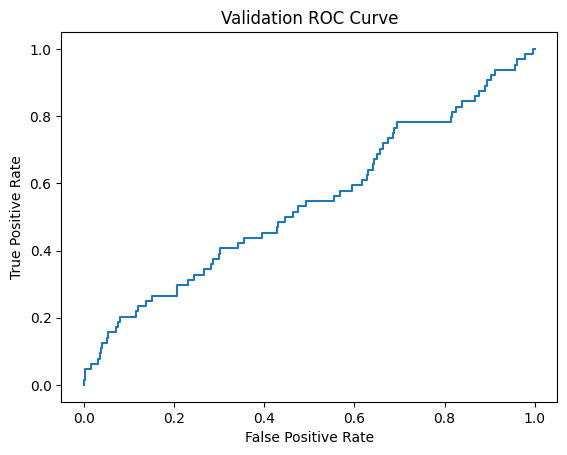

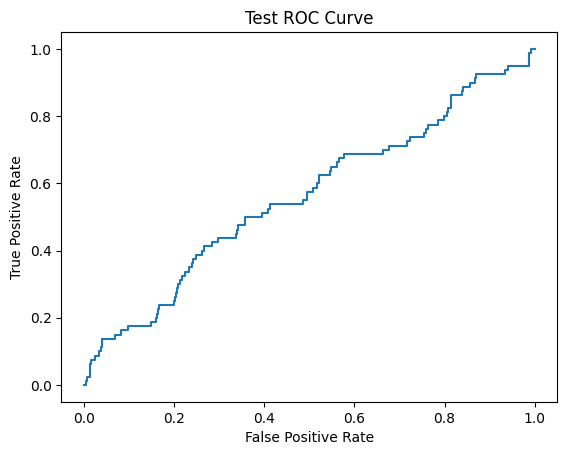

In [58]:
#rf = RandomForestClassifier(max_depth = 3,
#                                                          min_samples_leaf = 40,
#                                                          min_samples_split = 660,
#                                                          max_features="sqrt", random_state=42,n_estimators=70)
# rf = GradientBoostingClassifier(random_state=10)
rf = xgb.XGBClassifier()
rf.fit(X_train_selected_imputed, y_train)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
val_auc = cross_val_score(rf, X_val_selected_imputed, y_val, scoring='roc_auc', cv=cv).mean()
test_auc = cross_val_score(rf, X_test_selected_imputed, y_test, scoring='roc_auc', cv=cv).mean()

print('Validation AUC:', val_auc)
print('Test AUC:', test_auc)

val_prob = rf.predict_proba(X_val_selected_imputed)[:, 1]
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_prob)
plt.plot(fpr_val, tpr_val)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.show()

test_prob = rf.predict_proba(X_test_selected_imputed)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_prob)
plt.plot(fpr_test, tpr_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

# Initialize a range of random forest classifiers with different numbers of trees
num_trees = [1, 2, 4, 8, 16, 32, 64, 100]
classifiers = [RandomForestClassifier(n_estimators=n, random_state=42, criterion= "log_loss") for n in num_trees]

# Fit each classifier to the training data and calculate the loss on the training and validation data
train_losses = []
val_losses = []
for clf in classifiers:
    clf.fit(X_train_selected_imputed, y_train)
    train_loss = 1 - clf.score(X_train_selected_imputed, y_train)
    val_loss = 1 - clf.score(X_val_selected_imputed, y_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot the training and validation loss as a function of thenumber of trees
plt.plot(num_trees, train_losses, label='Training Loss')
plt.plot(num_trees, val_losses, label='Validation Loss')
plt.xlabel('Number of Trees')
plt.ylabel('Loss')
plt.title('Random Forest Classifier Loss')
plt.legend()
plt.show()

In [62]:
import matplotlib.pyplot as plt

# Train a Keras model and retrieve the history object
history = clf.fit(X_train_selected_imputed, y_train, validation_data=(X_val_selected_imputed, y_val))

# Plot the training and validation loss as a function of the number of epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TypeError: ignored